In [1]:
import gensim
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import nltk
from tqdm import tqdm
import typing

In [2]:
from gensim import downloader

In [3]:
%%time
# download the Word2Vec Google News 300 dimensional embeddings
word2vec_google_news_300: gensim.models.keyedvectors.KeyedVectors = downloader.load('word2vec-google-news-300')

[=================================================-] 99.8% 1660.1/1662.8MB downloaded
CPU times: user 7min 4s, sys: 33.6 s, total: 7min 37s
Wall time: 8min 26s


Note that this is an instance of `KeyedVectors`, which is basically an instantiation of the vectors corresponding to a set vocabulary of words.

In [4]:
type(word2vec_google_news_300)

gensim.models.keyedvectors.KeyedVectors

So, for example, if you try to take a word that's not present in the vocabulary, you'll get a `KeyError`, because it can't look up the word you're asking about.

This is because we're taking embeddings that are the result of evaluating an already-trained neural network on a vocabulary of words, and trying to look up the vectors that are closest to a given input word. So the word you ask about (in this case, `notaword`) has to be present in the vocabulary, and then it will look up the closest words from that vocabulary.

In [5]:
try:
    word2vec_google_news_300.most_similar('notaword')
except KeyError as e:
    print(e)

"Key 'notaword' not present in vocabulary"


In [6]:
# and we use it like this
word2vec_google_news_300.most_similar('cat', topn=3)

[('cats', 0.8099379539489746),
 ('dog', 0.760945737361908),
 ('kitten', 0.7464985251426697)]

In [7]:
%%time
words: typing.List[str] = ['Paris', 'Python', 'Sunday', 'Tolstoy', 'Twitter', 'bachelor', 'delivery', 'election', 'expensive', 'experience', 'financial', 'food', 'iOS', 'peace', 'release', 'war']

# there's a `topn`-length list for each word above
topn = 30
word_clusters: typing.List[typing.List[str]] = []
                            # len 16    len 30    len 300
word_cluster_embeddings: typing.List[typing.List[np.ndarray]] = []
# for each of our query words
for word in tqdm(words):
    most_similar_words: typing.List[str] = []
    most_similar_words_embeddings: typing.List[np.ndarray] = []
    # generate a length 30 list of most similar words from our vocabulary
    for similar_word, similarity in word2vec_google_news_300.most_similar(word, topn=topn):
        # and add those words and their embeddings back
        most_similar_words.append(similar_word)
        most_similar_words_embeddings.append(word2vec_google_news_300[similar_word])
    # then, append the list of most similar words and their embeddings to the aggregate list
    word_cluster_embeddings.append(most_similar_words_embeddings)
    word_clusters.append(most_similar_words)

100%|██████████| 16/16 [00:07<00:00,  2.15it/s]

CPU times: user 10.2 s, sys: 1.19 s, total: 11.4 s
Wall time: 7.47 s


In [8]:
print(f"There are {len(word_cluster_embeddings)} words")
print(f"We retrieved the top {len(word_cluster_embeddings[0])} most similar words to each of those words")
print(f"Each of those most similar words has a {len(word_cluster_embeddings[0][0])}-dimensional vector")
word_cluster_embeddings_np = np.array(word_cluster_embeddings)
# n samples, by m similar words, by d dimensions
n, m, d = word_cluster_embeddings_np.shape
print(f"We cast the list of lists of arrays into a {word_cluster_embeddings_np.shape} numpy array")

There are 16 words
We retrieved the top 30 most similar words to each of those words
Each of those most similar words has a 300-dimensional vector
We cast the list of lists of arrays into a (16, 30, 300) numpy array


In [9]:
tsne_model_en_2d = TSNE(
    perplexity=15,
    n_components=2,
    init='pca',
    n_iter=3500,
    random_state=32,
    n_jobs=-1
)

We need to take our (n, m, d) array, and reshape it for input into the t-SNE algorithm.

We reshape it into (n * m, d), so we think about this as having n * m samples of word-similar word pairs, and a column for each dimension of our embedding vectors.


In [10]:
tsne_training_set = word_cluster_embeddings_np.reshape(n * m, d)
# we now have a dataset of (words)x(similarity words) rows, and (dimensions) columns
print(tsne_training_set.shape)

(480, 300)


In [11]:
%%time
t_sne_embeddings = tsne_model_en_2d.fit_transform(tsne_training_set)
t_sne_embeddings.shape

CPU times: user 17.6 s, sys: 165 ms, total: 17.8 s
Wall time: 10.2 s


(480, 2)

Now we have 480 samples with 2 columns. So t-SNE gave us values for the x and y coordinates for each pair of word and similarity word.

We need to reshape those compressed embeddings so that we have 3 dimensions, this way when we zip the compressed embeddings with the original words, we have a first dimension of length 16.

In [12]:
reshaped_t_sne_embeddings = t_sne_embeddings.reshape(n, m, 2)
print(reshaped_t_sne_embeddings.shape)

(16, 30, 2)


In [13]:
colors = cm.rainbow(np.linspace(0, 1, len(words)))

# zip takes each element of these 4 iterables, and stitches them together
print("These 4 iterables are zipped together; the np array first dimension matches the size")
print(len(words))
print(reshaped_t_sne_embeddings.shape)
print(len(word_clusters))
print(len(colors))

print("We have an entry for each of our original words:")
print("A single example of the zipped data looks like:")
for word, embeddings, similar_words, color in zip(words, reshaped_t_sne_embeddings, word_clusters, colors):
    print(word)
    print(embeddings.shape)
    print(similar_words)
    print(color)
    break

These 4 iterables are zipped together; the np array first dimension matches the size
16
(16, 30, 2)
16
16
We have an entry for each of our original words:
A single example of the zipped data looks like:
Paris
(30, 2)
['Parisian', 'Hopital_Europeen_Georges_Pompidou', 'Spyker_D##_Peking', 'France', 'Pantheon_Sorbonne', 'Aeroports_De', 'Grigny_south', 'Place_Denfert_Rochereau', 'guest_Olivier_Dolige', 'Lazard_Freres_Banque', 'Pitié_Salpêtrière_Hospital', 'Le_Meridien_Etoile', 'Nanterre_west', 'Colombes', 'Créteil', 'Christian_Châtelet', 'Melun', 'Garches_west', 'French', 'Avignon', 'Cergy_Pontoise', 'Saint_Ouen', 'Vandore_reported', 'Ivry_sur_Seine', 'Brussels', 'Suresnes_west', 'Elysées', 'By_PETA_Protester', 'Trappes', 'Issy_les_Moulineaux']
[0.5 0.  1.  1. ]


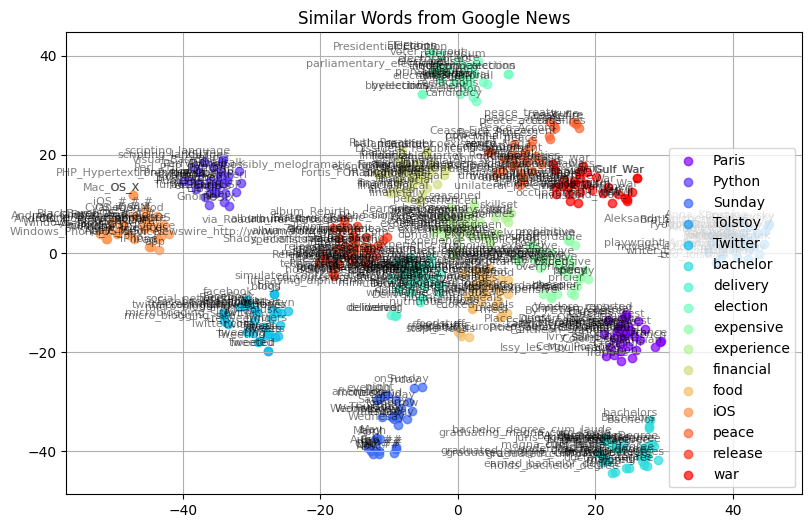

In [14]:
figsize = (9.5, 6)
plt.figure(figsize=figsize)

for word, embeddings, similar_words, color in zip(words, reshaped_t_sne_embeddings, word_clusters, colors):
    x = embeddings[:, 0]
    y = embeddings[:, 1]
    plt.scatter(x, y, c=[color], alpha=0.7, label=word)
    for i, similar_word in enumerate(similar_words):
        plt.annotate(similar_word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), textcoords="offset points", ha="right", va="bottom", size=8)

plt.legend(loc=4)
plt.title("Similar Words from Google News")
plt.grid(True)
plt.show()